In [1]:
####マーク付き点過程によるyelpデータセット解析####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import itertools
import scipy
from datetime import time, datetime, timedelta
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
import MeCab
import neologdn
import json

np.random.seed(98537)

In [2]:
##データの読み込み
user_df0 = pd.read_json("D:/Statistics/data/yelp_dataset/user.json", lines=True)
business_df0 = pd.read_json("D:/Statistics/data/yelp_dataset/business.json", lines=True)
checkin_df0 = pd.read_json("D:/Statistics/data/yelp_dataset/checkin.json", lines=True)

In [3]:
##レビューデータの読み込みとデータフレームへの変換
#jsonファイルを読み込み
f = open("D:/Statistics/data/yelp_dataset/review.json", encoding="utf-8")
temp = [json.loads(line) for i, line in enumerate(f)]
N = len(temp)

#numpy配列を作成
review_id = np.array(np.repeat("", N), dtype="object")
user_id = np.array(np.repeat("", N), dtype="object")
business_id = np.array(np.repeat("", N), dtype="object")
stars = np.array(np.repeat(0.0, N), dtype="float16")
useful = np.array(np.repeat(0.0, N), dtype="float16")
funny = np.array(np.repeat(0.0, N), dtype="float16")
cool = np.repeat(0.0, N)
date = np.array(np.repeat("", N), dtype="object")

for i in range(N):
    review_id[i] =  temp[i]["review_id"]
    user_id[i] = temp[i]["user_id"]
    business_id[i] = temp[i]["business_id"]
    stars[i] = temp[i]["stars"]
    useful[i] = temp[i]["useful"]
    funny[i] = temp[i]["funny"]
    cool[i] = temp[i]["cool"]
    date[i] = temp[i]["date"]
del temp

#データフレームに変換
review_df0 = pd.DataFrame({"review_id": review_id, "user_id": user_id, "business_id": business_id, "stars": stars, "useful": useful,
                          "funny": funny, "cool": cool, "date": date})

In [4]:
##ユーザーとロケーションのidを作成
#日付でデータを絞り込む
index_date = np.array(np.where(review_df0["date"] >= "2010-01-01 00:00:00")[0], dtype="int")
review_df = review_df0.iloc[index_date]
review_df.index = np.arange(review_df.shape[0])

#ユーザーとロケーションのidを定義
user_freq = review_df["user_id"].value_counts()
business_freq = review_df["business_id"].value_counts()
target_user = np.array(user_freq.iloc[np.where(user_freq > 50)[0]].index)
target_business = np.array(business_freq.iloc[np.where(business_freq > 50)[0]].index)
hh = target_user.shape[0]; item = target_business.shape[0]
user_df = pd.DataFrame({"d_id": np.arange(hh), "user_id": target_user})
business_df = pd.DataFrame({"v_id": np.arange(item), "business_id": target_business})

#review履歴のデータフレームを作成
target_df = pd.merge(review_df, user_df, on="user_id", how="left")
target_df = pd.merge(target_df, business_df, on="business_id", how="left")
index_target = np.array(np.where((pd.isna(target_df["d_id"])==False) & (pd.isna(target_df["v_id"])==False))[0], dtype="int")
target_df = target_df.iloc[index_target]
target_df.index = np.arange(target_df.shape[0])
target_df["d_id"] = np.array(target_df["d_id"], dtype="int")
target_df["v_id"] = np.array(target_df["v_id"], dtype="int")
target_df = target_df[["date", "review_id", "user_id", "d_id", "business_id", "v_id", "stars", "useful", "funny", "cool"]]
N = target_df.shape[0]
target_df = target_df.sort_values(by=["d_id", "date"])
target_df.index = np.arange(N)
d_id1 = np.array(target_df["d_id"])
item_id1 = np.array(target_df["v_id"])
del review_df

(array([549703., 210251.,  83031.,  39424.,  21920.,  12757.,   8158.,
          5394.,   3639.,   3714.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

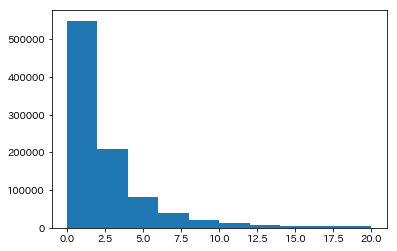

In [25]:
plt.hist(np.array(target_df["useful"], dtype="int"), range=(0, 20))

In [33]:

np.sqrt(0.001)

0.03162277660168379

In [21]:
target_df

,date,review_id,user_id,d_id,business_id,v_id,stars,useful,funny,cool
0,2010-01-08 19:31:42,oeei1tb-6mBlq_ARy3m09A,CxDOIDnH8gp9KXzpBHJYXw,0,TCr7O2v9L7sH-CZbtpz0KQ,25346,2.0,1.0,1.0,1.0
1,2010-01-12 19:32:07,7FkooikLSGyTUfNTtHE-6w,CxDOIDnH8gp9KXzpBHJYXw,0,4t_RBsTtU7hhVYJweh46Uw,24387,3.0,3.0,3.0,1.0
2,2010-01-25 04:08:47,47povAMFrG2bC1U8IG05nQ,CxDOIDnH8gp9KXzpBHJYXw,0,lkM72Y21bjBqUGaW7iL7tQ,15079,2.0,2.0,2.0,1.0
3,2010-01-26 18:48:28,19Rc4LU170TpTOome19nQQ,CxDOIDnH8gp9KXzpBHJYXw,0,syRPwPqdV6h3eenuV1d6rg,7408,3.0,1.0,0.0,0.0
4,2010-02-02 23:39:20,v7uMW8gchnCL19DezJVXAQ,CxDOIDnH8gp9KXzpBHJYXw,0,pDMxIQoqkZJeUe2r8XIVKQ,21344,1.0,1.0,1.0,1.0
5,2010-02-03 22:40:57,tpZ-_fpkHuLZhfsEggLwUQ,CxDOIDnH8gp9KXzpBHJYXw,0,G6EkDTXZ6zMUovg7JTG4YQ,6276,3.0,0.0,0.0,0.0
6,2010-02-05 19:12:45,qXtXfXenbcyMV8tsQDpRxA,CxDOIDnH8gp9KXzpBHJYXw,0,1NZonnS3SpogXaZJigVgqA,16198,4.0,6.0,1.0,2.0
7,2010-02-06 16:34:14,j-hAnpTzFmdc1OLCJEPR1A,CxDOIDnH8gp9KXzpBHJYXw,0,dJnF_GUWdoX3tUucpKbYMg,17198,3.0,5.0,1.0,1.0
8,2010-02-08 04:06:03,GPDGwACnm3b2lw5tfyNAJw,CxDOIDnH8gp9KXzpBHJYXw,0,1lReBAd4iLe0rBLKiurw7Q,15183,3.0,4.0,2.0,3.0
9,2010-02-11 19:30:05,R385m8TCEYt585D4LvFqbg,CxDOIDnH8gp9KXzpBHJYXw,0,7fbR8yaEV_aAdOaaE4-0FA,8267,3.0,1.0,0.0,1.0


In [ ]:
##インデックスを作成
#ユーザーのインデックス
d_list1 = [i for i in range(hh)]
pt1 = np.repeat(0, hh)
for i in range(hh):
    d_list1[i] = np.array(np.where(d_id1==i)[0], dtype="int")
    pt1[i] = d_list1[i].shape[0]
pt_id1 = np.array(list(itertools.chain(*[np.arange(pt1[i]) for i in range(hh)])))
target_df["no"] = pt_id1
target_df = target_df[["date", "no",  "review_id", "user_id", "d_id", "business_id", "v_id", "stars", "useful", "funny", "cool"]]

#アイテムのインデックス
item_list1 = [i for i in range(item)]
item_n1 = np.repeat(0, item)
for i in range(item):
    item_list1[i] = np.array(np.where(item_id1==i)[0], dtype="int")
    item_n1[i] = item_list1[i].shape[0]

In [ ]:
##ユーザーとアイテムデータを作成
#ユーザーのデータフレームを作成
user_data = pd.merge(user_df0, user_df, on="user_id", how="left")
user_data = user_data.iloc[np.array(np.where(pd.isna(user_data["d_id"])==False)[0], dtype="int")]
user_data["d_id"] = np.array(user_data["d_id"], dtype="int")
user_data = user_data[["d_id", "user_id", "name", "yelping_since", "fans", "friends", "review_count", "elite", "average_stars",
                       "compliment_cool", "compliment_cute", "compliment_funny", "compliment_hot", "compliment_list", 
                       "compliment_more", "compliment_note", "compliment_photos", "compliment_plain", "compliment_profile",
                       "compliment_writer", "cool", "elite", "fans", "funny", "useful"]]
user_data = user_data.sort_values(by="d_id")
user_data.index = np.arange(hh)

#アイテムのデータフレームを作成
business_data = pd.merge(business_df0, business_df, on="business_id", how="left")
business_data = business_data.iloc[np.array(np.where(pd.isna(business_data["v_id"])==False)[0], dtype="int")]
business_data["v_id"] = np.array(business_data["v_id"], dtype="int")
business_data = business_data[["business_id", "v_id", "name", "postal_code", "state", "city", "address", "latitude", "longitude",
                               "categories", "attributes", "hours", "is_open", "review_count", "stars"]]
business_data = business_data.sort_values(by="v_id")
business_data.index = np.arange(item)

In [ ]:
##訪問履歴データを作成
#日付を文字列型から日付型に変更
target_df["new_date"] = pd.to_datetime(target_df["date"])
target_df = target_df[["date", "new_date", "no",  "review_id", "user_id", "d_id", "business_id", "v_id",
                       "stars", "useful", "funny", "cool"]]

#訪問履歴と日付の差分を格納
get_date = 90
get_n = 25
item_id2 = np.full((N, get_n), item)
Z = np.array(np.full((N, get_n), -1), dtype="int16")
for i in range(hh):
    if i%1000==0:
        print(i)
    index = d_list1[i]
    target_date = target_df["new_date"].iloc[index]
    target_item = target_df["v_id"].iloc[index]
    for j in range(index.shape[0]):
        if j==0:
            continue
        get = np.arange(np.max(np.array([j-get_n, j-j])), j)
        x = np.array((target_date.iloc[j] - target_date.iloc[get]).apply(lambda x: x.days), dtype="int16")
        index_get = (np.where(x <= get_date)[0])[::-1]
        item_id2[index[j], np.arange(index_get.shape[0])] = np.array(target_item.iloc[get[index_get]])
        Z[index[j], np.arange(index_get.shape[0])] = x[index_get]
        
#経過日数の減衰関数を設定
new_Z = (np.abs(Z - get_date) / get_date) * np.array(item_id2!=item, dtype="float")

In [ ]:
##応答変数を定義
#元データとターゲットデータを結合
review_df0["new_date"] = pd.to_datetime(review_df0["date"])
review_df0 = review_df0.sort_values(by=["user_id", "new_date"])
review_df0.index = np.arange(review_df0.shape[0])
temp_df = pd.merge(review_df0, pd.concat((target_df[["review_id", "no"]] , pd.DataFrame({"num": np.arange(N)})), axis=1),
                   on="review_id", how="left")

#1回目のレビューの時間差を定義
y = np.repeat(0.0, N)
index = np.where(temp_df["no"]==0.0)[0]
index1 = np.where(np.array(temp_df["user_id"].iloc[index])==np.array(temp_df["user_id"].iloc[index-1]))[0]
index2 = np.where(np.array(temp_df["user_id"].iloc[index])!=np.array(temp_df["user_id"].iloc[index-1]))[0]
target1 = np.array(temp_df["num"].iloc[index[index1]], dtype="int")
target2 = np.array(temp_df["num"].iloc[index[index2]], dtype="int")
x1 = temp_df["new_date"].iloc[index[index1]]; x1.index = np.arange(x1.shape[0])
x2 = temp_df["new_date"].iloc[index[index1]-1]; x2.index = np.arange(x2.shape[0])
y[target1] = np.array((x1 - x2).dt.total_seconds() / 60 / 60 / 24)
y[target2] = 0.0

#2回目以降のレビューの時間差を定義
index = np.where(temp_df["no"] >= 1.0)[0]
target = np.array(temp_df["num"].iloc[index], dtype="int")
x1 = temp_df["new_date"].iloc[index]; x1.index = np.arange(x1.shape[0])
x2 = temp_df["new_date"].iloc[index-1]; x2.index = np.arange(x2.shape[0])
y[target] = np.array((x1 - x2).dt.total_seconds() / 60 / 60 / 24)

In [ ]:
##学習データとテストデータに分割
#学習データとテストデータのインデックス
index_learn = np.array(np.where((target_df["date"] < "2018-04-01 00:00:00") & (y > 0.0) & (y < 200.0))[0], dtype="int")
index_test = np.array(np.where((target_df["date"] >= "2018-04-01 00:00:00") & (y > 0.0) & (y < 200.0))[0], dtype="int")

#データを分割
target_df1 = target_df.iloc[index_learn]; target_df0 = target_df.iloc[index_test]
N1 = target_df1.shape[0]; N0 = target_df0.shape[0]
target_df1.index = np.arange(N1); target_df0.index = np.arange(N0)
d_id11 = d_id1[index_learn]; d_id01 = d_id1[index_test]
item_id11 = item_id1[index_learn]; item_id01 = item_id1[index_test]
item_id12 = item_id2[index_learn, ]; item_id02 = item_id2[index_test, ]
Z1 = Z[index_learn, ]; Z0 = Z[index_test, ]
new_Z1 = new_Z[index_learn, ]; new_Z0 = new_Z[index_test, ]
y1 = y[index_learn]; y0 = y[index_test]

In [ ]:
#ユーザーインデックスを作成
d_list1 = [i for i in range(hh)]
d_vec1 = [i for i in range(hh)]
for i in range(hh):
    d_list1[i] = np.array(np.where(d_id11==i)[0], dtype="int")
    d_vec1[i] = np.repeat(1, d_list1[i].shape[0])

In [ ]:
#アイテムインデックスを作成
index_history = [j for j in range(get_n)]
item_list1 = [i for i in range(item)]
item_list21 = [i for i in range(item)]
item_list22 = [i for i in range(item)]
item_vec1 = [i for i in range(item)]
d_list2 = [i for i in range(item)]
for j in range(get_n):
    index_history[j] = np.array(np.where(item_id12[:, j]!=item)[0], dtype="int")
for i in range(item):
    if i%1000==0:
        print(i)
    temp_list1 = [j for j in range(get_n)]
    temp_list2 = [j for j in range(get_n)]
    for j in range(get_n):
        temp_list1[j] = np.array(np.where(item_id12[:, j]==i)[0], dtype="int")
        temp_list2[j] = d_id11[temp_list1[j]]
    item_list1[i] = np.array(np.where(item_id11==i)[0], dtype="int")
    item_list21[i] = temp_list1
    item_list22[i] = np.array(np.unique(np.where(item_id12==i)[0]), dtype="int")
    item_vec1[i] = np.repeat(1, item_list1[i].shape[0])
    d_list2[i] = temp_list2

In [ ]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##切断指数分布の乱数を生成する関数
def rtexp(gamma, a, b):
    #切断指数分布の乱数を生成
    FA = scipy.stats.expon.cdf(a, scale=gamma)
    FB = scipy.stats.expon.cdf(b, scale=gamma)
    par = scipy.stats.expon.ppf(np.random.uniform(0, 1, a.shape[0])*(FB-FA)+FA, scale=gamma)
    return par

In [ ]:
##アルゴリズムの設定
R = 300
keep = 1
burnin = int(100/keep)
iter = 0
disp = 10
e1 = 0.001
e2 = 0.0025
L = 3

In [ ]:
##データの設定
#応答変数の設定
y_vec1 = y1[:, np.newaxis]
y_vec0 = y0[:, np.newaxis]
n_vec = np.repeat(1, N1)[:, np.newaxis]

#基底数の設定
k = 7
k_vec = np.repeat(1.0, k)

#学習用データのインデックスの作成
item_get = [j for j in range(get_n)]
z_get = [j for j in range(get_n)]
for j in range(get_n):
    index = index_history[j]
    item_get[j] = item_id12[index, j]
    z_get[j] = new_Z1[index, j]
    
#テストデータのインデックス
flag = np.array(np.in1d(item_id02, np.unique(item_id11)).reshape(N0, get_n), dtype="int16")
index_history0 = [j for j in range(get_n)]
item_get0 = [j for j in range(get_n)]
z_get0 = [j for j in range(get_n)]
for j in range(get_n):
    index = np.array(np.where(item_id02[:, j]!=item)[0], dtype="int")
    index_history0[j] = index
    item_get0[j] = item_id02[index, j]
    z_get0[j] = new_Z0[index, j] * flag[index, j]
index_evaluate1 = np.array(np.in1d(item_id01, np.unique(item_id11)), dtype="int")
index_evaluate2 = np.array(np.in1d(d_id01, np.unique(d_id11)), dtype="int")
index_evaluate = np.array(np.where((index_evaluate1 + index_evaluate2)==2)[0], dtype="int")

In [ ]:
##事前分布の設定
alpha = 0.5
beta = 1.0
s0 = 1.0
v0 = 1.0

In [ ]:
##パラメータの初期値
#ガンマ分布のパラメータ
alpha11 = 1.0; beta11 = 1.5
alpha12 = 1.0; beta12 = 1.5
alpha21 = 0.5; beta21 = 1.0
alpha22 = 0.5; beta22 = 1.0
tau = 0.2

#モデルパラメータの初期値
beta_u = np.random.gamma(alpha11, 1/beta11, hh)
beta_v = np.random.gamma(alpha12, 1/beta12, item)
theta_u1 = np.random.gamma(alpha11, 1/beta11, k*hh).reshape(hh, k)
theta_v1 = np.random.gamma(alpha12, 1/beta12, k*item).reshape(item, k)
theta_u2 = np.random.gamma(alpha21, 1/beta21, k*hh).reshape(hh, k)
theta_v2 = np.random.gamma(alpha22, 1/beta22, k*item).reshape(item, k)
gamma = np.random.gamma(0.5, 2.0, hh)

#モデルの期待値
beta_user = beta_u[d_id11]; beta_item = beta_v[item_id11]
uv1 = np.dot(theta_u1[d_id11, ] * theta_v1[item_id11, ], k_vec)
gamma_vec = gamma[d_id11]; theta_user2 = theta_u2[d_id11, ]
gamma_dt = np.zeros((N1, get_n))
uv2 = np.repeat(0.0, N1)
for j in range(get_n):
    index = index_history[j]
    gamma_dt[index, j] = gamma_vec[index] * z_get[j]
    uv2[index] += np.dot(theta_user2[index, ] * theta_v2[item_get[j], ], k_vec) * gamma_dt[index, j]
mu = uv1 + uv2

In [ ]:
##パラメータの格納用配列
BETA_U = np.zeros((int(R/keep), hh))
BETA_V = np.zeros((int(R/keep), item))
THETA_U1 = np.zeros((hh, k , int(R/keep)))
THETA_V1 = np.zeros((item, k , int(R/keep)))
THETA_U2 = np.zeros((hh, k , int(R/keep)))
THETA_V2 = np.zeros((item, k , int(R/keep)))
GAMMA = np.zeros((int(R/keep), hh))

In [ ]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##ユーザーパラメータをサンプリング
    #補助変数を更新
    theta_user1 = theta_u1[d_id11, ]; theta_item1 = theta_v1[item_id11, ]
    mu_dt = theta_user1 * theta_item1
    Lambda = mu_dt / mu[:, np.newaxis]

    #ガンマ分布のパラメータ
    lambda_y = Lambda * y_vec1
    W11 = np.zeros((hh, k)); W12 = np.zeros((hh, k))
    for i in range(hh):
        index = d_list1[i]
        W11[i, ] = np.dot(lambda_y[index, ].T, d_vec1[i])
        W12[i, ] = np.dot(theta_item1[index, ].T, d_vec1[i])
    W11 = W11 + alpha; W12 = W12 + beta

    #パラメータをサンプリング
    theta_u1 = np.random.gamma(W11, 1/W12)
    theta_user1 = theta_u1[d_id11, ]
    uv1 = np.dot(theta_user1 * theta_item1, k_vec)

    
    ##アイテムパラメータをサンプリング
    #補助変数を更新
    mu = uv1 + uv2 
    mu_dt = theta_user1 * theta_item1
    Lambda = mu_dt / mu[:, np.newaxis]

    #ガンマ分布のパラメータ
    lambda_y = Lambda * y_vec1
    H11 = np.zeros((item, k)); H12 = np.zeros((item, k))
    for i in range(item):
        index = item_list1[i]
        H11[i, ] = np.dot(lambda_y[index, ].T, item_vec1[i])
        H12[i, ] = np.dot(theta_user1[index, ].T, item_vec1[i])
    H11 = H11 + alpha; H12 = H12 + beta

    #パラメータをサンプリング
    theta_v1 = np.random.gamma(H11, 1/H12)
    theta_item1 = theta_v1[item_id11, ]
    uv1 = np.dot(theta_user1 * theta_item1, k_vec)
    
    
    ##トリガーのユーザー特徴行列をサンプリング
    #補助変数を更新
    mu = uv1 + uv2 
    theta_user2 = theta_u2[d_id11, ]
    theta_dt = np.zeros((N1, k))
    uv_dt = np.zeros((N1, k))
    for j in range(get_n):
        index = index_history[j]
        theta_target = theta_user2[index, ]
        uv_target = (theta_target * theta_v2[item_get[j], ]) * gamma_dt[index, j][:, np.newaxis]
        theta_dt[index, ] += uv_target
    Lambda = uv_dt / mu[:, np.newaxis]

    #ガンマ分布のパラメータ
    lambda_y = Lambda * y_vec1
    W21 = np.zeros((hh, k)); W22 = np.zeros((hh, k))
    for i in range(hh):
        index = d_list1[i]
        W21[i, ] = np.dot(lambda_y[index, ].T, d_vec1[i])
        W22[i, ] = np.dot(theta_dt[index, ].T, d_vec1[i])
    W21 = W21 + alpha; W22 = W22 + beta

    #パラメータをサンプリング
    theta_u2 = np.random.gamma(W21, 1/W22)
    theta_user2 = theta_u2[d_id11, ]

    #期待値を更新
    uv2 = np.repeat(0.0, N1)
    for j in range(get_n):
        index = index_history[j]
        uv2[index] += np.dot(theta_user2[index, ] * theta_v2[item_get[j], ], k_vec) * gamma_dt[index, j]


    ##トリガーのアイテム特徴行列をサンプリング
    #パラメータの格納用配列
    mu = uv1 + uv2 
    theta_dt = np.zeros((N1, k))
    uv_dt = np.zeros((N1, k))
    H21 = np.zeros((item, k))
    H22 = np.zeros((item, k))

    ##アイテムごとの事後分布のパラメータ
    for i in range(item):
        #補助変数を更新
        for j in range(get_n):
            index = item_list21[i][j]
            theta_target = theta_user2[index, ]
            uv_target = (theta_target * theta_v2[i, ]) * gamma_dt[index, j][:, np.newaxis]
            theta_dt[index, ] += uv_target / theta_v2[i, ]
            uv_dt[index, ] += uv_target
        index = item_list22[i]
        Lambda = uv_dt[index, ] / mu[index, np.newaxis]

        #ガンマ分布の事後分布のパラメータ　
        lambda_y = Lambda * y_vec1[index]
        H21[i, ] = np.sum(lambda_y, axis=0)
        H22[i, ] = np.sum(theta_dt[index, ], axis=0)
        theta_dt[index, ] = 0; uv_dt[index, ] = 0
    H21 = H21 + alpha; H22 = H22 + beta

    #パラメータをサンプリング
    theta_v2 = np.random.gamma(H21, 1/H22)

    
    #期待値を更新
    uv2 = np.repeat(0.0, N1)
    for j in range(get_n):
        index = index_history[j]
        uv2[index] += np.dot(theta_user2[index, ] * theta_v2[item_get[j], ], k_vec) * gamma_dt[index, j]


    ##トリガーの重みパラメータをサンプリング
    #補助変数を更新
    mu = uv1 + uv2
    par_dt = np.repeat(0.0, N1)
    weights_dt = np.repeat(0.0, N1)
    for j in range(get_n):
        index = index_history[j]
        theta_target = theta_user2[index, ]
        uv_target = np.dot(theta_target * theta_v2[item_get[j], ], k_vec) * gamma_dt[index, j]
        par_dt[index] += uv_target / gamma_vec[index]
        weights_dt[index] += uv_target
    Lambda = weights_dt / mu

    #ガンマ分布のパラメータ
    lambda_y = Lambda * y1
    G1 = np.repeat(0.0, hh); G2 = np.repeat(0.0, hh)
    for i in range(hh):
        index = d_list1[i]
        G1[i] = np.sum(lambda_y[index])
        G2[i] = np.sum(par_dt[index])
    G1 = G1 + alpha; G2 = G2 + beta

    #パラメータをサンプリング
    gamma = np.random.gamma(G1, 1/G2, hh)
    gamma_vec = gamma[d_id11]

    #期待値を更新
    gamma_dt = np.zeros((N1, get_n))
    uv2 = np.repeat(0.0, N1)
    for j in range(get_n):
        index = index_history[j]
        gamma_dt[index, j] = gamma_vec[index] * z_get[j]
        uv2[index] += np.dot(theta_user2[index, ] * theta_v2[item_get[j], ], k_vec) * gamma_dt[index, j]
    mu = uv1 + uv2

    
    ##パラメータの格納とサンプリング結果の表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = rp//keep
        BETA_U[mkeep, ] = beta_u
        BETA_V[mkeep, ] = beta_v
        THETA_U1[:, :, mkeep] = theta_u1
        THETA_V1[:, :, mkeep] = theta_v1
        THETA_U2[:, :, mkeep] = theta_u2
        THETA_V2[:, :, mkeep] = theta_v2
        GAMMA[mkeep, ] = gamma

    if rp%disp==0:
        #学習データに対する対数尤度を更新
        mu = uv1 + uv2 
        LL1 = np.sum(scipy.stats.expon.logpdf(x=y1, scale=mu))

        #テストデータに対する対数尤度を更新
        uv01 = np.dot(theta_u1[d_id01, ] * theta_v1[item_id01, ], k_vec)
        gamma_vec0 = gamma[d_id01]; theta_user02 = theta_u2[d_id01, ]
        gamma_dt0 = np.zeros((N0, get_n))
        uv02 = np.repeat(0.0, N0)
        for j in range(get_n):
            index = index_history0[j]
            gamma_dt0[index, j] = gamma_vec0[index] * z_get0[j]
            uv02[index] += np.dot(theta_user02[index, ] * theta_v2[item_get0[j], ], k_vec) * gamma_dt0[index, j]
        mu0 = uv01 + uv02
        LL0 = np.sum(scipy.stats.expon.logpdf(x=y0[index_evaluate], scale=mu0[index_evaluate]))
        
        #サンプリング結果の表示
        print(rp)
        print(np.round([LL1, LL0], 1))